<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

---

In [ ]:
#| include: false
from vertex_simulation.primitives import *
from vertex_simulation.simulation import *
import torch, numpy as np, matplotlib.pylab as plt
from mpl_toolkits.mplot3d import axes3d
# after you modify this notebook use "nbdev_build_docs" to build the docs (and readme.md)
# and nbdev_clean_nbs to remove notebook metadata before pushing it

In [ ]:
#| include: false
device=torch.device('cpu')
if torch.cuda.device_count():
    device=torch.device('cuda:0')
dtype = torch.float32

print(f'Device: {device}\ndtype: {dtype}')

Device: cpu
dtype: torch.float32


## Anisotropic contractions

In [ ]:
import networkx as nx

In [ ]:
# let's seed RNG for sanity and reproducibility
rng = np.random.default_rng(seed=42)

# define cell monolayer
v_x,regions =unit_hexagons(10,10) # unit hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += rng.normal(size=(v_x.shape[0], v_x.shape[1]),scale=.2)

In [ ]:
cell_graph = Monolayer(vertices=Vertex(v_x.copy().tolist(),dtype=dtype), 
                       edges=torch.tensor(edge_list), 
                       cells=cells)
cell_graph.to_(device)

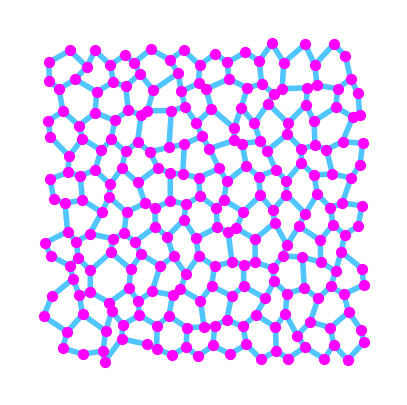

In [ ]:
Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

In [ ]:
# Define energy function
omega_0 = torch.tensor([np.pi/2],dtype=dtype,device=device)
phase = torch.rand((len(edge_list),1)).type(dtype).to(device)
p_keep = 0.5 # fraction to keep active
e_ij_on = (torch.rand((len(edge_list),1))<p_keep).type(dtype).to(device)
omega = torch.randn_like(e_ij_on) + omega_0

def monolayer_energy(monolayer_,Tau):
    Perm = cell_graph.perimeter()
    Area = cell_graph.area()
    Leng = cell_graph.length()
    
    gamma_ij  = e_ij_on*torch.cos(omega*Tau+phase)**2
    gamma_ij_by_lij = Leng*gamma_ij
    Energy_tot = torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)
    return Energy_tot, gamma_ij

In [ ]:
# Networkx's edge ordering is different
edge_idx = dict(zip([tuple(e) for e in cell_graph.edges.tolist()],range(cell_graph.edges.shape[0])))
edge_idx_order = [edge_idx[e if e in edge_idx else (e[1],e[0])] for e in Gnx.edges ]
def draw_w_tension(i):
    pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {verts_frames[i]:2.3f}')
    #node_color=range(24), node_size=800, cmap=plt.cm.Blues
    nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',
            edge_color=line_tensions[i].numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

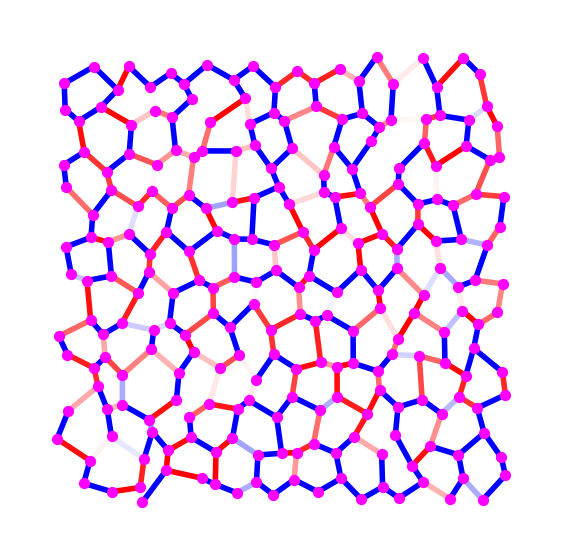

In [ ]:
_,Contractions = monolayer_energy(cell_graph,0)
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,node_color='#FF00FF',
            edge_color=Contractions.cpu().numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

In [ ]:
# Simulation param-s
Dt = 2**-7 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
t_total = 2**12

cell_graph.vertices.requires_grad_(True)

Integration (Euler's method):
t=4.000: E= 87.2; aver |dx/dt|= 0.33
t=8.000: E=83.37; aver |dx/dt|= 0.34
t=12.000: E=80.94; aver |dx/dt|= 0.37
t=16.000: E=82.95; aver |dx/dt|= 0.41
t=20.000: E=81.72; aver |dx/dt|= 0.41
t=24.000: E=74.63; aver |dx/dt|= 0.44
t=28.000: E=78.38; aver |dx/dt|= 0.38
t=32.000: E=80.63; aver |dx/dt|= 0.41


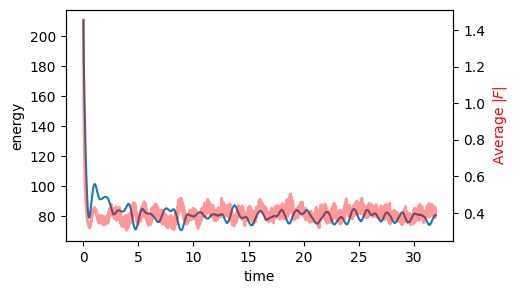

Perimeters:tensor([5.8019, 6.4631, 6.1368, 5.7350, 6.1934, 6.4358, 6.5304, 6.5015, 5.7386,
        5.7353, 5.8666, 6.6421, 6.5862, 6.7758, 5.7543, 6.2330, 6.3325, 5.5823,
        6.1760, 5.6452, 5.8176, 6.0330, 6.5538, 6.2079, 5.9385, 5.9475, 6.8929,
        7.3365, 6.2983, 5.4419, 5.8056, 6.2107, 6.2516, 6.9176, 5.7750, 6.4367,
        6.4177, 6.1236, 5.7740, 6.8567, 6.3852, 6.8278, 5.6767, 6.1503, 6.3418,
        6.3760, 6.6247, 6.1660, 6.5440, 5.8099, 6.3547, 6.1257, 6.8165, 6.1271,
        6.1931, 7.2163, 6.1477, 6.6071, 6.9242, 6.6485, 6.1714, 5.9072, 7.1340,
        6.4114, 6.8041, 6.3591, 5.9710, 6.1684, 6.3083, 6.4332, 6.7965, 6.3073,
        6.8615, 5.8837, 6.5986, 7.0944, 6.1947, 5.9315, 5.9413, 6.4814, 5.8378,
        6.3665, 6.2523, 6.0595, 5.9474, 6.2796, 6.9019, 6.5032, 6.6630, 6.2718,
        7.1358, 5.5638, 6.3471, 5.6447, 5.9311, 6.1854, 7.2084, 6.0546, 6.1623,
        5.7083])
Areas:tensor([2.2340, 2.1976, 2.1875, 2.0861, 2.1882, 2.1139, 2.2247, 2.2052, 1.9702,
      

In [ ]:
# Numerical integration
print('Integration (Euler\'s method):')

for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    t.append(t[-1]+Dt) # update last frame time
    # total potential energy of the system:
    E,Contractions = monolayer_energy(cell_graph,t[-1]) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    verts_t.append(cell_graph.vertices.x.detach().cpu().clone())
    verts_frames.append(t[-1])
    line_tensions.append(Contractions.detach().cpu().clone())
    
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( monolayer_energy( cell_graph,t[-1])[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import PIL

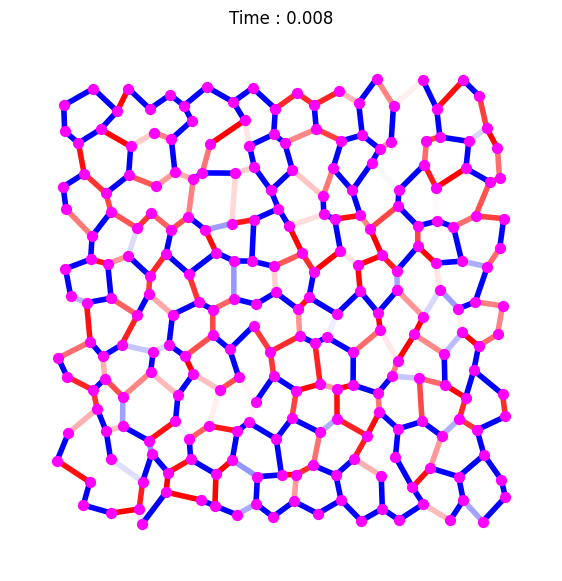

In [ ]:
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw_w_tension(0)
plt.show()
plt.close()

anim = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                               frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
HTML(anim.to_jshtml())

**Save as GIF**

In [ ]:
pil_images=[]
for i in range(0,len(verts_t),100):
    fig = plt.figure(figsize=[7,7])
    fig.clf()
    ax = fig.subplots()
    ax.axis(False);
    draw_w_tension(i)
#     plt.show()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(
        PIL.Image.frombytes('RGBA', canvas.get_width_height(), 
                            bytes(canvas.get_renderer().buffer_rgba()) )
    )
    plt.close()

In [ ]:
pil_images[0].save('sim_anisotropic_contraction.gif', format='GIF',
                   append_images=pil_images[1:], save_all=True, duration=100, loop=0)